### Objective: To train the model using clustering.

### K-Means Clustering

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

C:\Users\Bhuvana Chandrahasan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Reading Data 

In [2]:
project_data = pd.read_csv(r'C:\Users\Bhuvana Chandrahasan\train_data.csv')
resource_data = pd.read_csv(r'C:\Users\Bhuvana Chandrahasan\resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print(project_data.columns)

Number of data points in train data (109248, 17)
Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')


In [4]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   
76127              Special Needs                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1

In [5]:
print("Number of data points in resource data", resource_data.shape)
print("Number of data points in resource data", resource_data.columns)
resource_data.head(2)

Number of data points in resource data (1541272, 4)
Number of data points in resource data Index(['id', 'description', 'quantity', 'price'], dtype='object')


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [6]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [7]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [8]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
1       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

  school_state                Date project_grade_category  \
0           CA 2016-04-27 00:27:36          Grades PreK-2   
1           UT 2016-04-27 00:31:25             Grades 3-5   

  project_subject_categories            project_subject_subcategories  \
0             Math & Science  Applied Sciences, Health & Life Science   
1              Special Needs                            Special Needs   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  Imagine being 8-9 years old. You're in your th...   

                                     project_essay_2  \
0  My students come from a variety of backgrounds...   
1  Most of my students have autism, anxiety, anot...   

                                     project_essay_3  \
0  Each month I try to do several science or STEM...   
1  It is tough to do more than one thing at a tim...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  When my students are able to calm themselves d...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

   teacher_number_of_previously_posted_projects  project_is_approved   price  \
0                                            53                    1  725.05   
1                                             4                    1  213.03   

   quantity  
0         4  
1         8

In [9]:
project_data.shape

(109248, 19)

In [10]:
final_appr = project_data[project_data['project_is_approved'] == 1]
final_appr = final_appr.sample(n=8400) 
final_appr.shape

(8400, 19)

In [11]:
final_rej =  project_data[project_data['project_is_approved'] == 0]
final_rej = final_rej.sample(n=1600)
final_rej.shape

(1600, 19)

In [12]:
final=pd.concat([final_appr,final_rej])
final=final.sort_values('Date', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final.shape

(10000, 19)

In [13]:
project_data = final

In [14]:
project_data.shape

(10000, 19)

### 1.1 Preprocessing of project_subject_categories

In [15]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


### 1.2 Preprocessing of project_subject_subcategories 

In [16]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 2.Text Preprocessing

### 2.1 Preprocessing of essay

In [17]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [18]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
10       57854  p099430  4000cfe0c8b2df75a218347c1765e283            Ms.   
49       59086  p226990  49e24758e486dabc3dbeb6e55c84532b           Mrs.   

   school_state                Date project_grade_category  \
10           IL 2016-04-27 07:19:44          Grades PreK-2   
49           UT 2016-04-27 10:42:43             Grades 3-5   

                               project_title  \
10  A flexible classroom for flexible minds!   
49            Inquiry Notebooks for Students   

                                      project_essay_1  \
10  My students yearn for a classroom environment ...   
49  Every day is an adventure in my classroom. Stu...   

                                      project_essay_2  \
10  I have the privilege of teaching an incredible...   
49  My school is full of diverse students from man...   

                                      project_essay_3  \
10  Ideally, I would love to delve right into \"fl...   
49  Students will use the inquiry notebooks in all...   

                                      project_essay_4  \
10  This project will be so beneficial for my stud...   
49  My project will make a difference in my studen...   

                             project_resource_summary  \
10  My students need 5 Hokki Stools and an easel o...   
49  My students need inquiry notebooks to help the...   

    teacher_number_of_previously_posted_projects  project_is_approved   price  \
10                                             1                    1  393.83   
49                                             0                    1   75.19   

    quantity                clean_categories  \
10         9               Literacy_Language   
49        64  Math_Science Literacy_Language   

                        clean_subcategories  \
10                                 Literacy   
49  EnvironmentalScience Literature_Writing   

                                                essay  
10  My students yearn for a classroom environment ...  
49  Every day is an adventure in my classroom. Stu...

In [19]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)

My students yearn for a classroom environment that matches their desire to learn. With education changing daily, we need a classroom that can meet the needs of all of my first graders.I have the privilege of teaching an incredible group of six and seven year olds who absolutely LOVE to learn. I am completely blown away by their love for learning. Each day is a new adventure as they enjoy learning from nonfiction text and hands on activities. Many of my students are very active learners who benefit from kinesthetic activities. Sometimes learning, while sitting in a seat, is difficult. I want every child the opportunity to focus their energy in order to do their best in school!Ideally, I would love to delve right into \"flexible seating\" where students are provided many different seating options (chairs, hokki stools, on mats on the ground, etc.) and they have the freedom to choose which ever seat they feel they need. My student would be able to choose which seating option will best hel

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent = decontracted(project_data['essay'].values[2000])
print(sent)
print("="*50)

My P.E. classes consist of students ranging from kindergarten through 4th grade. These guys love to move their bodies during our 30-minute gym time. We are a lower income school and they do not always have the opportunity to participate in organized activities due to cost and transportation issues.\r\nSafety concerns often prevent playing or riding bikes around the neighborhood. A combination of these factors often result in my students choosing sedentary type activities versus staying physically active outside of their school day.\r\n\r\n\r\nHow do children feel about squats, jumping jacks, knee raises, pushups, and exercise in general? BORING! That is, until you roll them a stability ball (fit drum), hand them a couple of drumsticks, and turn up the volume to some catchy dance tunes. Before you know it, these same kids are begging to exercise with the fit drums in order to share routines that were created by THEMSELVES, at their own HOMES, and on their own TIME.\r\n\r\nPhysically act

In [22]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My P.E. classes consist of students ranging from kindergarten through 4th grade. These guys love to move their bodies during our 30-minute gym time. We are a lower income school and they do not always have the opportunity to participate in organized activities due to cost and transportation issues.  Safety concerns often prevent playing or riding bikes around the neighborhood. A combination of these factors often result in my students choosing sedentary type activities versus staying physically active outside of their school day.      How do children feel about squats, jumping jacks, knee raises, pushups, and exercise in general? BORING! That is, until you roll them a stability ball (fit drum), hand them a couple of drumsticks, and turn up the volume to some catchy dance tunes. Before you know it, these same kids are begging to exercise with the fit drums in order to share routines that were created by THEMSELVES, at their own HOMES, and on their own TIME.    Physically active children

In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My P E classes consist of students ranging from kindergarten through 4th grade These guys love to move their bodies during our 30 minute gym time We are a lower income school and they do not always have the opportunity to participate in organized activities due to cost and transportation issues Safety concerns often prevent playing or riding bikes around the neighborhood A combination of these factors often result in my students choosing sedentary type activities versus staying physically active outside of their school day How do children feel about squats jumping jacks knee raises pushups and exercise in general BORING That is until you roll them a stability ball fit drum hand them a couple of drumsticks and turn up the volume to some catchy dance tunes Before you know it these same kids are begging to exercise with the fit drums in order to share routines that were created by THEMSELVES at their own HOMES and on their own TIME Physically active children become physically active adult

In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|███████████████████████████████████| 10000/10000 [00:24<00:00, 407.51it/s]


In [26]:
# after preprocesing
preprocessed_essays[2000]

'p e classes consist students ranging kindergarten 4th grade guys love move bodies 30 minute gym time lower income school not always opportunity participate organized activities due cost transportation issues safety concerns often prevent playing riding bikes around neighborhood combination factors often result students choosing sedentary type activities versus staying physically active outside school day children feel squats jumping jacks knee raises pushups exercise general boring roll stability ball fit drum hand couple drumsticks turn volume catchy dance tunes know kids begging exercise fit drums order share routines created homes time physically active children become physically active adults donation fit drum project help students reach goal active least 60 minutes day students drum anything anywhere decided project would help stay active outside school day believe fit drums help active practicing creating high energy routines home turning fit drum routines videos accessed home c

### 2.2 Preprocessing of project_title

In [27]:
# printing some random reviews
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)

A flexible classroom for flexible minds!
Inner City Reading Intervention Needs
Have You Heard, \"If You Can't Sit Still, Stand Up?\"


In [28]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent = decontracted(project_data['project_title'].values[2000])
print(sent)
print("="*50)

Drumming Our Way to a Healthier Lifestyle


In [30]:
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Drumming Our Way to a Healthier Lifestyle


In [31]:
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Drumming Our Way to a Healthier Lifestyle


In [32]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████████████████████████████| 10000/10000 [00:01<00:00, 6603.05it/s]


In [33]:
# after preprocesing
preprocessed_essays[2000]

'drumming way healthier lifestyle'

In [34]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
10       57854  p099430  4000cfe0c8b2df75a218347c1765e283            Ms.   
49       59086  p226990  49e24758e486dabc3dbeb6e55c84532b           Mrs.   

   school_state                Date project_grade_category  \
10           IL 2016-04-27 07:19:44          Grades PreK-2   
49           UT 2016-04-27 10:42:43             Grades 3-5   

                               project_title  \
10  A flexible classroom for flexible minds!   
49            Inquiry Notebooks for Students   

                                      project_essay_1  \
10  My students yearn for a classroom environment ...   
49  Every day is an adventure in my classroom. Stu...   

                                      project_essay_2  \
10  I have the privilege of teaching an incredible...   
49  My school is full of diverse students from man...   

                                      project_essay_3  \
10  Ideally, I would love to delve right into \"fl...   
49  Students will use the inquiry notebooks in all...   

                                      project_essay_4  \
10  This project will be so beneficial for my stud...   
49  My project will make a difference in my studen...   

                             project_resource_summary  \
10  My students need 5 Hokki Stools and an easel o...   
49  My students need inquiry notebooks to help the...   

    teacher_number_of_previously_posted_projects  project_is_approved   price  \
10                                             1                    1  393.83   
49                                             0                    1   75.19   

    quantity                clean_categories  \
10         9               Literacy_Language   
49        64  Math_Science Literacy_Language   

                        clean_subcategories  \
10                                 Literacy   
49  EnvironmentalScience Literature_Writing   

                                                essay  
10  My students yearn for a classroom environment ...  
49  Every day is an adventure in my classroom. Stu...

In [35]:
print(project_data.shape)
print(project_data.columns)

(10000, 20)
Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'essay'],
      dtype='object')


###  4.Vectorizing Text data

### 4.1 Essay

In [36]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(project_data['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
essay_bow = vectorizer.transform(project_data['essay'].values)

print("After vectorizations")
print("Shape of matrix essay_bow:", essay_bow.shape)

After vectorizations
Shape of matrix essay_bow: (10000, 6390)


### 4.2 Project_title

In [37]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(project_data['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
title_bow = vectorizer.transform(project_data['project_title'].values)

print("After vectorizations")
print("Shape of matrix project_title:", title_bow.shape)

After vectorizations
Shape of matrix project_title: (10000, 673)


### 4.3  Project_resource_summary

In [38]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(project_data['project_resource_summary'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
summ_bow = vectorizer.transform(project_data['project_resource_summary'].values)

print("After vectorizations")
print("Shape of matrix project_title:", summ_bow.shape)

After vectorizations
Shape of matrix project_title: (10000, 1545)


###  5.Catogorical features:one hot encoding

### 5.1 Clean_categories

In [39]:
vectorizer = CountVectorizer()
# we use the fitted CountVectorizer to convert the text to vector
clean_category_ohe = vectorizer.fit_transform(project_data['clean_categories'].values)

print("After vectorizations")
print(clean_category_ohe.shape)
print(vectorizer.get_feature_names())

After vectorizations
(10000, 9)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


###  5.2 Clean_subcategories

In [40]:
vectorizer = CountVectorizer()

# we use the fitted CountVectorizer to convert the text to vector
clean_subcategory_ohe = vectorizer.fit_transform(project_data['clean_subcategories'].values)

print("After vectorizations")
print(clean_subcategory_ohe.shape)
print(vectorizer.get_feature_names())

After vectorizations
(10000, 30)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


###  5.3 Teacher_prefix

In [41]:
project_data.teacher_prefix = project_data.teacher_prefix.fillna('')
project_data['teacher_prefix'].value_counts()

Mrs.       5273
Ms.        3508
Mr.        1015
Teacher     203
Dr.           1
Name: teacher_prefix, dtype: int64

In [42]:
vectorizer = CountVectorizer()

# we use the fitted CountVectorizer to convert the text to vector
teacher_ohe = vectorizer.fit_transform(project_data['teacher_prefix'].values)


print("After vectorizations")
print(teacher_ohe.shape)
print(vectorizer.get_feature_names())

After vectorizations
(10000, 5)
['dr', 'mr', 'mrs', 'ms', 'teacher']


### 5.4 School_state

In [43]:
vectorizer = CountVectorizer()

# we use the fitted CountVectorizer to convert the text to vector
state_ohe = vectorizer.fit_transform(project_data['school_state'].values)

print("After vectorizations")
print(state_ohe.shape)
print(vectorizer.get_feature_names())

After vectorizations
(10000, 51)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### 5.5 Project_grade_category 

In [44]:
project_data.project_grade_category = project_data.project_grade_category.str.replace('\s+', '_')
project_data.project_grade_category = project_data.project_grade_category.str.replace('-', '_')
project_data['project_grade_category'].value_counts()

Grades_PreK_2    4074
Grades_3_5       3391
Grades_6_8       1563
Grades_9_12       972
Name: project_grade_category, dtype: int64

In [45]:
vectorizer = CountVectorizer(lowercase=False, binary=True)

# we use the fitted CountVectorizer to convert the text to vector
grade_ohe = vectorizer.fit_transform(project_data['project_grade_category'].values)

print("After vectorizations")
print(grade_ohe.shape)
print(vectorizer.get_feature_names())

After vectorizations
(10000, 4)
['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']


### 6.Numerical features 

### 6.1 Price

In [46]:
from sklearn.preprocessing import StandardScaler
standard_vec = StandardScaler(with_mean = False)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standard_vec.fit(project_data['price'].values.reshape(-1,1))

price = standard_vec.transform(project_data['price'].values.reshape(-1,1))


print("After vectorizations")
print(price.shape)

After vectorizations
(10000, 1)


### 6.2 Teacher_number_of_previously_posted_projects

In [47]:
from sklearn.preprocessing import StandardScaler
standard_vec = StandardScaler(with_mean = False)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standard_vec.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

prev_projects_std = standard_vec.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(prev_projects_std.shape)

C:\Users\Bhuvana Chandrahasan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\Bhuvana Chandrahasan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



After vectorizations
(10000, 1)


### 6.3 Quantity 

In [48]:
from sklearn.preprocessing import StandardScaler
standard_vec = StandardScaler(with_mean = False)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standard_vec.fit(project_data['quantity'].values.reshape(-1,1))

quantity = standard_vec.transform(project_data['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(quantity.shape)

C:\Users\Bhuvana Chandrahasan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\Bhuvana Chandrahasan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



After vectorizations
(10000, 1)


## 7. K-Means


### Merging all the above features 

In [49]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
bow = hstack((essay_bow,title_bow,summ_bow,clean_category_ohe,clean_subcategory_ohe,state_ohe,teacher_ohe,grade_ohe,price,prev_projects_std,quantity)).tocsr()

print("Final Data matrix")
print(bow.shape)

Final Data matrix
(10000, 8710)


### use only top 5000 Features using selectKbest

In [50]:
y=project_data['project_is_approved']

In [51]:
from sklearn.feature_selection import SelectKBest, chi2

x_bow = SelectKBest(chi2, k=5000).fit_transform(bow,y)

In [52]:
x_bow.shape

(10000, 5000)

### K-Means

100%|████████████████████████████████████████| 9/9 [3:41:13<00:00, 1857.05s/it]


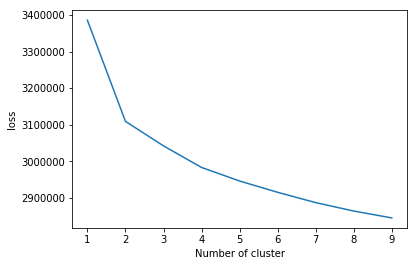

In [56]:
from sklearn.cluster import KMeans

loss = []
k=range(1, 10)

for k in tqdm(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x_bow)
    loss.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, 10), loss)
plt.xlabel("Number of cluster")
plt.ylabel("loss")
plt.show()

In [57]:
#Perfoming kmeans with best k
kmeans = KMeans(n_clusters=2)
kmeans.fit(x_bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [59]:
#Distributing different datapoints to respective clusters
cluster_1=[]
cluster_2=[]

for i in range(x_bow.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster_1.append(project_data.iloc[i])
    elif kmeans.labels_[i] == 1:
        cluster_2.append(project_data.iloc[i])

In [62]:
positive=0
negative=0
words=len(cluster_1)
for i in cluster_1:
    if i['project_is_approved']==1:
        positive=positive+1
    else:
        negative=negative+1

print("Projects Approved %age in cluster 1 ",(positive/words*100))
print("Projects Not Approved %age in cluster 1 ",(negative/words*100))

Projects Approved %age in cluster 1  87.18550821871855
Projects Not Approved %age in cluster 1  12.814491781281449


In [64]:
positive=0
negative=0
words=len(cluster_2)
for i in cluster_2:
    if i['project_is_approved']==1:
        positive=positive+1
    else:
        negative=negative+1

print("Projects Approved %age in cluster 2 ",(positive/words*100))
print("Projects Not Approved %age in cluster 2 ",(negative/words*100))

Projects Approved %age in cluster 2  82.64710072659923
Projects Not Approved %age in cluster 2  17.35289927340077


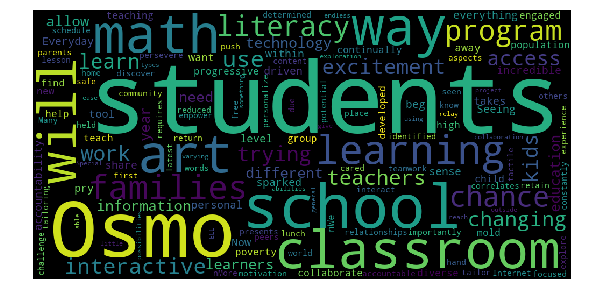

In [65]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud
essay_cluster1 =cluster_1[0]['essay']

wordcloud = WordCloud(width = 1000, height = 500).generate(essay_cluster1)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
   
plt.show()

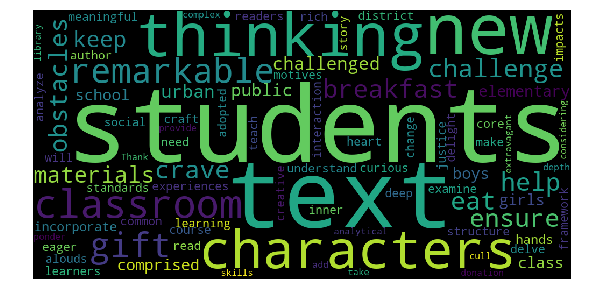

In [66]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud
essay_cluster2=cluster_2[0]['essay']

wordcloud = WordCloud(width = 1000, height = 500).generate(essay_cluster2)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# Observations:
1.We can see that all 2 clusters have around 82% positive and 12% negative points.  

2.Most common  words in cluster 1 and 2 are "students","classroom," "learning".  


## Agglomerative

In [53]:
x_bow = x_bow.toarray()

In [54]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
from sklearn.cluster import AgglomerativeClustering
Agg = AgglomerativeClustering(n_clusters = 2)
Agg.fit(x_bow)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=2,
            pooling_func=<function mean at 0x0000009C7F144598>)

In [55]:
#Distributing different datapoints to respective clusters
cluster_1=[]
cluster_2=[]

for i in range(x_bow.shape[0]):
    if Agg.labels_[i] == 0:
        cluster_1.append(project_data.iloc[i])
    elif Agg.labels_[i] == 1:
        cluster_2.append(project_data.iloc[i])

In [56]:
positive=0
negative=0
words=len(cluster_1)
for i in cluster_1:
    if i['project_is_approved']==1:
        positive=positive+1
    else:
        negative=negative+1

print("Projects Approved %age in cluster 1 ",(positive/words*100))
print("Projects Not Approved %age in cluster 1 ",(negative/words*100))

Projects Approved %age in cluster 1  83.17757009345794
Projects Not Approved %age in cluster 1  16.822429906542055


In [61]:
positive=0
negative=0
words=len(cluster_2)
for i in cluster_2:
    if i['project_is_approved']==1:
        positive=positive+1
    else:
        negative=negative+1

print("Projects Approved %age in cluster 2 ",(positive/words*100))
print("Projects Not Approved %age in cluster 2 ",(negative/words*100))

Projects Approved %age in cluster 2  89.34733683420856
Projects Not Approved %age in cluster 2  10.652663165791449


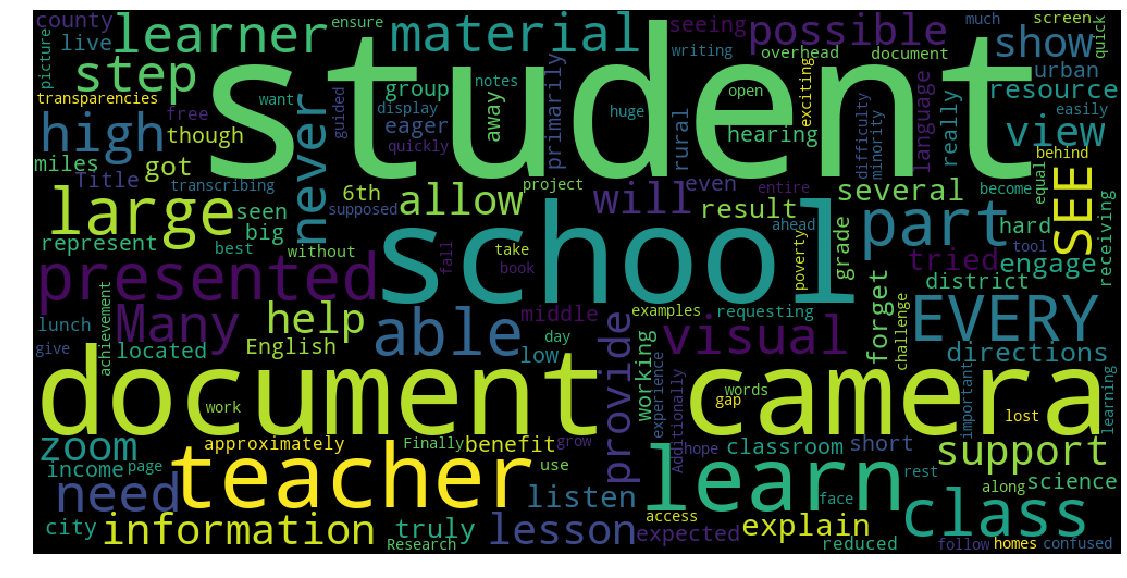

In [60]:
from wordcloud import WordCloud
#convert list to string and generate
essay_cluster1=cluster_1[0]['essay']
wordcloud = WordCloud(width = 1000, height = 500).generate(essay_cluster1)
plt.figure(figsize=(25,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

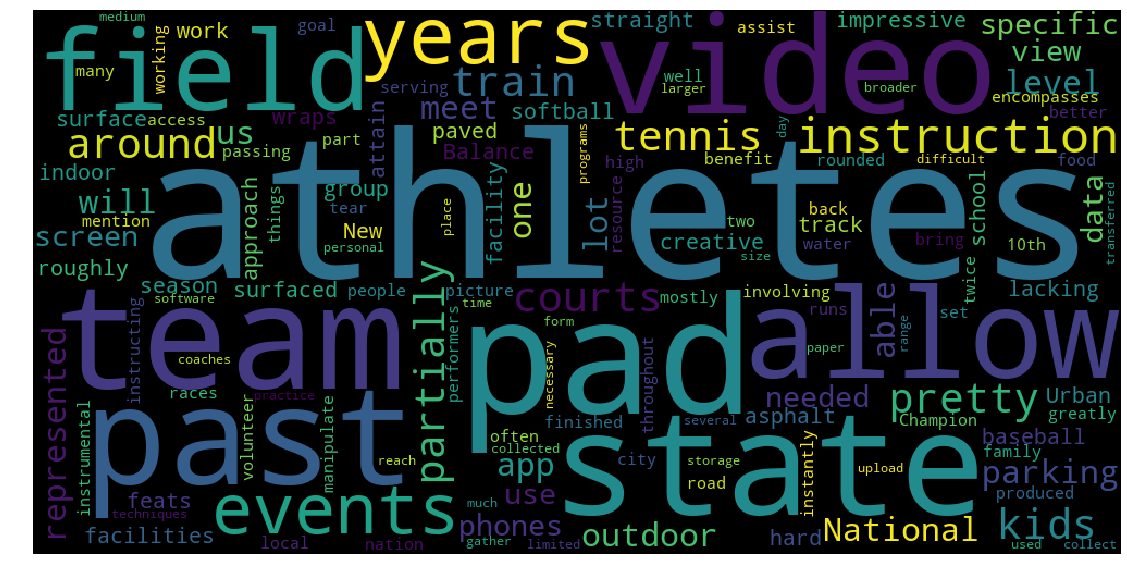

In [62]:
from wordcloud import WordCloud
#convert list to string and generate
essay_cluster2=cluster_2[0]['essay']
wordcloud = WordCloud(width = 1000, height = 500).generate(essay_cluster2)
plt.figure(figsize=(25,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

## Observations:

1.We can see that,the 2 clusters have around 82% positive and 10% negative points.

2.Cluster1 and Cluster2 does not have any common words.

## DBSCAN

In [54]:
#https://datascience.stackexchange.com/questions/10162/knn-distance-plot-for-determining-eps-of-dbscan
from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(10,0.5,metric='euclidean')
neigh.fit(x_bow)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=0.5)

In [55]:
p=neigh.kneighbors(x_bow, 10, return_distance=True)

In [73]:
i=0
distance=[]
while(i<10000):
    distance.append(p[0][i][9])
    i=i+1

In [74]:
distance.sort()

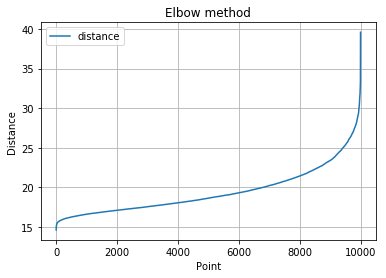

In [75]:
plt.plot(distance,label="distance")
plt.legend()
plt.xlabel("Point")
plt.ylabel("Distance")
plt.title("Elbow method")
plt.grid()
plt.show()

In [76]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=20, min_samples=10).fit(x_bow)

In [77]:
labels = db.labels_

In [78]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)   
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 2359


In [84]:
#Distributing different datapoints to respective clusters
cluster_1=[]
for i in range(x_bow.shape[0]):
    if db.labels_[i] == 0:
        cluster_1.append(project_data.iloc[i])
    else :
        pass

In [85]:
positive=0
negative=0
words=len(cluster_1)
for i in cluster_1:
    if i['project_is_approved']==1:
        positive=positive+1
    else:
        negative=negative+1

print("Projects Approved %age in cluster 1 ",(positive/words*100))
print("Projects Not Approved %age in cluster 1 ",(negative/words*100))

Projects Approved %age in cluster 1  82.82947258212275
Projects Not Approved %age in cluster 1  17.170527417877242


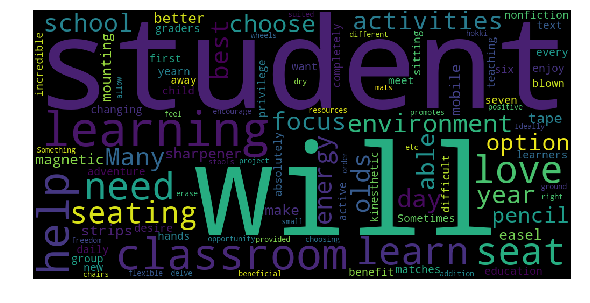

In [87]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud
words1=cluster_1[0]['essay']
wordcloud = WordCloud(width = 1000, height = 500).generate(words1)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Observations:

1.We can see that the cluster have around 82% positive and 17% negative points.  
2.Most frequent words in cluster 1 are "students" , "classroom", "learning", "classroom".  


In [1]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Model","Vectorizer","Hyperparameter","Clusters"]
x.add_row(["K-Means","BOW","k=2",2])
x.add_row(["Agglomerative","BOW","-",2])
x.add_row(["DBSCAN","BOW","eps=20,min_samples=10",1])
print(x)


+---------------+------------+-----------------------+----------+
|     Model     | Vectorizer |     Hyperparameter    | Clusters |
+---------------+------------+-----------------------+----------+
|    K-Means    |    BOW     |          k=2          |    2     |
| Agglomerative |    BOW     |           -           |    2     |
|     DBSCAN    |    BOW     | eps=20,min_samples=10 |    1     |
+---------------+------------+-----------------------+----------+
